In [5]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, clone
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from econml.dml import CausalForestDML, LinearDML
from econml.orf import DMLOrthoForest
from econml.cate_interpreter import SingleTreePolicyInterpreter, SingleTreeCateInterpreter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

c:\Users\jadrk\Dropbox\Colab Notebooks\MICS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

The MICSU5 dataset (22,410 observations; 1,420 columns) is the under-5 sample from UNICEF MICS. All fields below exist in the file and are used in the cleaning/modeling steps.

| **Feature Name** | Role | Type | Details |
|------------------|------|------|---------|
| **diarrhea** | Outcome (Y1) | Binary | Child had diarrhea in the last 2 weeks (0/1). |
| **WQ15** | Treatment (T) | Categorical | Reported action to make water safer; rows with "Do not know/missing" are removed. |
| **water_treatment** | Treatment (binary T) | Binary | Indicator for whether any water treatment was reported (1) vs none (0); used for the binary-treatment rerun. |
| **WQ26** | Control (X)/Outcome (Y2) | Continuous | E. coli count, household sample (CFU/100ml); parsed to numeric, 991/992 set to missing. |
| **WQ27** | Control (X) | Continuous | E. coli count, source water (CFU/100ml); parsed to numeric, 991/992 set to missing. |
| **windex5** | Confounder (W) | Categorical | Household wealth quintile. |
| **HH6** | Control (X) | Categorical | Urban vs rural household location. |
| **helevel** | Control (X) | Categorical | Highest education level of the household head. |
| **HH7** | Control (X) | Categorical | Region indicator. |
| **HH7A** | Control (X) | Categorical | District; high missingness handled with an explicit missing category. |
| **ethnicity** | Control (X) | Categorical | Household ethnicity. |
| **WQ17** | Control (X) | Categorical | Source of water type. |
| **HL4** | Control (X) | Categorical | Child gender. |
| **AN4** | Control (X) | Categorical | Child age quintile. |
| **HHSEX** | Control (X) | Categorical | Sex of household head. |
| **WQ12** | Confounder (W) | Categorical | Sample location (source vs. container). |
| **WQ18** | Confounder (W) | Categorical | Whether the water source was shown/accessible. |
| **WQ19** | Confounder (W) | Categorical | Whether source water was collected. |
| **WQ21** | Confounder (W) | Categorical | Blank water sample availability; missing values kept as their own category. |

Notes: WQ14 is not present in MICSU5, so WQ15 is used as the treatment. WQ29 and HH26C were dropped from modeling to avoid NaN-related failures; secondary outcomes ever and BMI are available but not modeled here.

In [6]:
train = pd.read_csv("mics_u5.csv", low_memory=False)
train.shape

(22410, 1420)

In [7]:
train.head()

,HH1,HH2,LN,UF1,UF2,UFINT,UF3,UF4,UF5,UF6,...,WQ15_g_98,WQ15_g_99,WS10_g_0,WS10_g_1,WS10_g_2,WS10_g_3,WS10_g_98,WS10_g_99,rainy_season,water_treatment3
0,1,5,7,1,5,12,7,3,12,1,...,0,0,1,0,0,0,0,0,1,0.0
1,1,5,8,1,5,12,8,2,12,1,...,0,0,1,0,0,0,0,0,1,0.0
2,1,14,5,1,14,15,5,3,15,1,...,0,0,1,0,0,0,0,0,1,0.0
3,1,22,5,1,22,15,5,2,15,1,...,0,0,1,0,0,0,0,0,1,0.0
4,1,22,6,1,22,15,6,1,15,1,...,0,0,1,0,0,0,0,0,1,0.0


In [8]:
# Clean and coerce raw inputs
required_cols = [
    'diarrhea', 'WQ15', 'water_treatment',
    'WQ26', 'WQ27',
    'windex5', 'HH6', 'helevel',
    'HH7', 'HH7A', 'ethnicity', 'WQ17', 'HL4', 'AN4', 'HHSEX',
    'WQ12', 'WQ18', 'WQ19', 'WQ21'
]
missing_cols = sorted(set(required_cols) - set(train.columns))
if missing_cols:
    raise ValueError(f"Faltan columnas en el dataset: {missing_cols}")

train = train[required_cols].copy()

train['WQ26_num'] = pd.to_numeric(train['WQ26'], errors='coerce').replace({991: np.nan, 992: np.nan})
train['WQ27_num'] = pd.to_numeric(train['WQ27'], errors='coerce').replace({991: np.nan, 992: np.nan})
train['WQ15'] = train['WQ15'].replace({'Treat: Do not know/missing':np.nan})

# Keep rows with observed outcome/treatment and valid E. coli counts
train = train.dropna(subset=['diarrhea', 'WQ15', 'WQ26_num', 'WQ27_num'])


y_diarrhea = train['diarrhea'].astype(int)

# Treatment
order = [
    'Treat: Nothing',
    'Treat: Strain with a cloth',
    'Treat: Boil',
    'Treat: Bleach/Chlorine',
    'Treat: Let it settle',
    'Treat: Aquatabs/PUR',
    'Treat: Other'
    ]

T = train['WQ15'].astype('category')
T = T.cat.reorder_categories(order, ordered=True)
t_names = list(T.cat.categories)

In [9]:
# Build model inputs (categorical encoding + no imputations)
x_cat = ['windex5', 'HH6', 'helevel', 'HH7', 'HH7A',
         'ethnicity', 'WQ17', 'HL4', 'AN4', 'HHSEX']
x_num = ['WQ26_num', 'WQ27_num']

w_cat = ['WQ12', 'WQ18', 'WQ19', 'WQ21']

X = pd.get_dummies(
    train[x_cat + x_num],
    columns=x_cat,
    drop_first=False
)
X = X.astype(float) 

W = pd.get_dummies(
    train[w_cat],
    columns=w_cat,
    drop_first=False
)

W = W.astype(float)

X.shape, W.shape, y_diarrhea.shape, len(np.unique(T))

((11385, 128), (11385, 14), (11385,), 7)

In [10]:
learner_y = LGBMRegressor(
    objective='binary',
    random_state=42,
    force_col_wise=True,
    n_jobs=1,
    verbose=-1
)

learner_t = LGBMClassifier(
    random_state=42,
    force_col_wise=True,
    n_jobs=1,
    verbose=-1
)


# Grid search
# XGBoost  
# Lasso
# Ridge
# ElasticNet
# RF

# y = diarrhea

## Modeling order for diarrhea
We'll start with `LinearDML` to set a baseline, then run `CausalForestDML` with L1/logistic nuisances, and finish with `CausalForestDML` using LightGBM nuisances.

### LinearDML first (diarrhea baseline)
Set up the double machine learning baseline before trying nonlinear forests.

In [11]:
ldml = LinearDML(
    model_y=learner_y,
    model_t=learner_t,
    discrete_treatment=True,
    cv=5,
    random_state=42
)

ldml.fit(
    Y=y_diarrhea,
    T=T,
    X=X,
    W=W
)


In [12]:
ldml.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
WQ26_num|WQ15_Treat: Bleach/Chlorine,0.031,0.126,0.249,0.804,-0.216,0.279
WQ26_num|WQ15_Treat: Boil,0.037,0.126,0.292,0.77,-0.21,0.284
WQ26_num|WQ15_Treat: Let it settle,0.031,0.126,0.246,0.806,-0.217,0.279
WQ26_num|WQ15_Treat: Nothing,0.035,0.126,0.28,0.779,-0.212,0.283
WQ26_num|WQ15_Treat: Other,0.116,0.132,0.877,0.38,-0.143,0.375
WQ26_num|WQ15_Treat: Strain with a cloth,0.035,0.126,0.28,0.779,-0.212,0.283
WQ27_num|WQ15_Treat: Bleach/Chlorine,-0.41,1.278,-0.321,0.748,-2.915,2.095
WQ27_num|WQ15_Treat: Boil,-0.426,1.278,-0.333,0.739,-2.93,2.079
WQ27_num|WQ15_Treat: Let it settle,-0.409,1.278,-0.32,0.749,-2.914,2.095
WQ27_num|WQ15_Treat: Nothing,-0.412,1.278,-0.322,0.747,-2.917,2.093


In [11]:
ldml.const_marginal_ate_inference(X)

### Causal Forest with nuisance Lasso (diarrhea)
Sparse logistic nuisances for outcome and treatment.

In [14]:
class LogitWrapper(BaseEstimator):
    def __init__(self, model): self.model = model
    def fit(self, X, y): self.clf_ = clone(self.model).fit(X, y); return self
    def predict(self, X): return self.clf_.predict_proba(X)[:, 1]

learner = make_pipeline(
    StandardScaler(), 
    SGDClassifier(loss='log_loss', penalty='l1', early_stopping=True, random_state=42)
)

lasso_diarrhea = CausalForestDML(
    model_y=LogitWrapper(learner), 
    model_t=learner,              
    discrete_treatment=True,      
    min_samples_leaf=200,
    random_state=42,
    n_jobs=-1
)


In [15]:
lasso_diarrhea.fit(y_diarrhea, T, X=X, W=W)

In [17]:
lasso_diarrhea.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE|WQ15_Treat: Bleach/Chlorine,0.194,0.019,10.442,0.0,0.157,0.23
ATE|WQ15_Treat: Boil,0.081,0.016,5.123,0.0,0.05,0.111
ATE|WQ15_Treat: Let it settle,0.025,0.016,1.579,0.114,-0.006,0.056
ATE|WQ15_Treat: Nothing,0.081,0.042,1.938,0.053,-0.001,0.162
ATE|WQ15_Treat: Other,-0.024,0.015,-1.629,0.103,-0.052,0.005
ATE|WQ15_Treat: Strain with a cloth,-0.028,0.03,-0.942,0.346,-0.088,0.031
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT|WQ15_Treat: Bleach/Chlorine,0.154,0.018,8.667,0.0,0.119,0.189
ATT|WQ15_Treat: Boil,0.048,0.018,2.675,0.007,0.013,0.084
ATT|WQ15_Treat: Let it settle,-0.037,0.015,-2.425,0.015,-0.068,-0.007


In [18]:
lasso_diarrhea.const_marginal_ate_inference(X)

### Causal Forest with LightGBM nuisances (diarrhea)
Tree-based nuisance models for comparison.

In [16]:
crf_diarrhea = CausalForestDML(
    model_y=learner_y, 
    model_t=learner_t, 
    min_samples_leaf=200,
    discrete_treatment=True,
    random_state=42,
    n_jobs=-1, 
    cv=4
)

In [17]:
crf_diarrhea.fit(y_diarrhea, T, X=X, W=W)

In [18]:
crf_diarrhea.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE|WQ15_Treat: Bleach/Chlorine,0.023,0.012,1.944,0.052,-0.0,0.045
ATE|WQ15_Treat: Boil,0.025,0.009,2.72,0.007,0.007,0.043
ATE|WQ15_Treat: Let it settle,0.013,0.009,1.435,0.151,-0.005,0.03
ATE|WQ15_Treat: Nothing,0.017,0.017,0.994,0.32,-0.016,0.05
ATE|WQ15_Treat: Other,-0.051,0.007,-7.674,0.0,-0.064,-0.038
ATE|WQ15_Treat: Strain with a cloth,-0.004,0.009,-0.466,0.641,-0.021,0.013
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT|WQ15_Treat: Bleach/Chlorine,0.032,0.007,4.332,0.0,0.017,0.046
ATT|WQ15_Treat: Boil,-0.023,0.011,-2.139,0.032,-0.045,-0.002
ATT|WQ15_Treat: Let it settle,-0.036,0.012,-2.987,0.003,-0.06,-0.013


In [19]:
crf_diarrhea.const_marginal_ate_inference(X)

In [20]:
intrp = SingleTreeCateInterpreter(max_depth=2)
intrp.interpret(crf_diarrhea, X)
plt.figure(figsize=(25, 8))
intrp.plot(feature_names=X.columns, treatment_names=t_names)

ImportError: matplotlib is no longer a dependency of the main econml package; install econml[plt] or econml[all] to require it, or install matplotlib separately, to use the tree interpreters

<Figure size 2500x800 with 0 Axes>

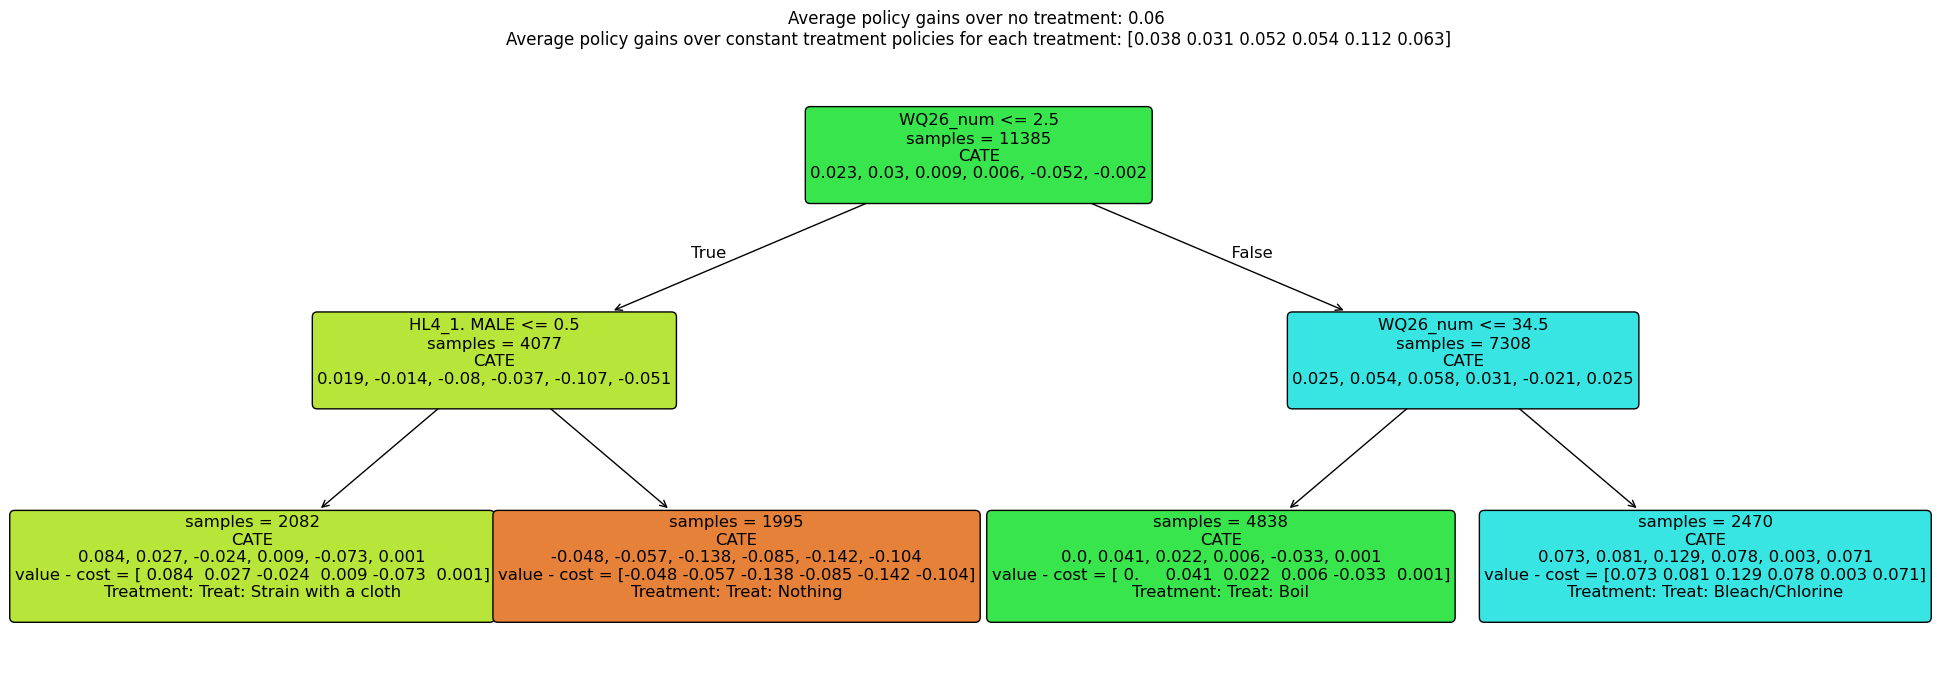

In [ ]:
intrp = SingleTreePolicyInterpreter(max_depth=2)
intrp.interpret(crf_diarrhea, X)
plt.figure(figsize=(25, 8))
intrp.plot(feature_names=X.columns, treatment_names=t_names)

## Repeat with binary treatment `water_treatment`
Before moving to the E. coli outcome, rerun the three estimators using the binary `water_treatment` indicator.

In [19]:
# Prepare binary treatment subset (water_treatment)
binary = train.dropna(subset=['water_treatment']).copy()

T_water = binary['water_treatment'].astype(int)
y_diarrhea_water = binary['diarrhea'].astype(int)

X_water = pd.get_dummies(
    binary[x_cat + x_num],
    columns=x_cat,
    drop_first=False
)
X_water = X_water.astype(float)

W_water = pd.get_dummies(
    binary[w_cat],
    columns=w_cat,
    drop_first=False
)
W_water = W_water.astype(float)

X_water.shape, W_water.shape, y_diarrhea_water.shape, T_water.value_counts()

((11378, 128),
 (11378, 14),
 (11378,),
 water_treatment
 0    9804
 1    1574
 Name: count, dtype: int64)

### LinearDML with binary treatment
Binary treatment keeps the same covariates but simplifies the treatment model.

In [20]:
ldml_water = LinearDML(
    model_y=clone(learner_y),
    model_t=clone(learner_t),
    discrete_treatment=True,
    cv=5,
    random_state=42
)

ldml_water.fit(
    Y=y_diarrhea_water,
    T=T_water,
    X=X_water,
    W=W_water
)

In [21]:
#ldml_water.summary()

In [22]:
ldml_water.ate_inference(X_water)

### Causal Forest with nuisance Lasso (binary treatment)
Reuse the sparse logistic nuisances for the binary indicator.

In [23]:
lasso_water = CausalForestDML(
    model_y=LogitWrapper(clone(learner)),
    model_t=clone(learner),
    discrete_treatment=True,
    min_samples_leaf=200,
    random_state=42,
    n_jobs=-1
)

lasso_water.fit(y_diarrhea_water, T_water, X=X_water.astype(float), W=W_water.astype(float))

In [24]:
lasso_water.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.019,0.121,0.158,0.874,-0.218,0.257
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.094,0.087,-1.09,0.276,-0.264,0.075
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.726,0.69,1.052,0.293,-0.627,2.079


In [25]:
lasso_water.ate_inference(X_water)

### Causal Forest with LightGBM nuisances (binary treatment)
Tree-based nuisances for the binary treatment arm.

In [ ]:
crf_water = CausalForestDML(
    model_y=clone(learner_y),
    model_t=clone(learner_t),
    min_samples_leaf=200,
    discrete_treatment=True,
    random_state=42,
    n_jobs=-1,
    cv=4
)

crf_water.fit(y_diarrhea_water, T_water, X=X_water, W=W_water)

In [ ]:
crf_water.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.017,0.018,-0.931,0.352,-0.053,0.019
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.008,0.004,-1.921,0.055,-0.016,0.0
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.073,0.129,-0.566,0.571,-0.326,0.18


In [ ]:
crf_water.ate_inference(X_water)

# y = E. coli

In [ ]:
# Outcome: E. coli concentration
y_ecoli = train['WQ26_num']

In [ ]:
learner_y = LGBMRegressor(
    objective='regression',
    random_state=42,
    force_col_wise=True,
    n_jobs=1,
    verbose=-1
)

## Modeling order for E. coli
LinearDML baseline first, then Causal Forest with L1/logistic nuisances, and finally Causal Forest with LightGBM nuisances.

### LinearDML first (E. coli baseline)
Continuous outcome with multinomial treatment.

In [ ]:
ldml_ecoli = LinearDML(
    model_y=learner_y,
    model_t=learner_t,
    discrete_treatment=True,
    cv=5,
    random_state=42
)

ldml_ecoli.fit(
    Y=y_ecoli,
    T=T,
    X=X,
    W=W
)

In [ ]:
#ldml_ecoli.summary()

In [ ]:
ldml_ecoli.const_marginal_ate_inference(X)

### Causal Forest with nuisance Lasso (E. coli)
Sparse nuisances: L1 regression for outcome and L1 logistic for treatment.

In [ ]:
lasso_ecoli = CausalForestDML(
    model_y=WeightedLassoCVWrapper(),
    model_t=clone(learner),
    discrete_treatment=True,
    min_samples_leaf=200,
    random_state=42,
    n_jobs=-1
)

lasso_ecoli.fit(y_ecoli, T, X=X.astype(float), W=W.astype(float))

In [ ]:
lasso_ecoli.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE|WQ15_Treat: Bleach/Chlorine,-0.001,0.001,-1.159,0.247,-0.003,0.001
ATE|WQ15_Treat: Boil,-0.002,0.001,-2.466,0.014,-0.004,-0.0
ATE|WQ15_Treat: Let it settle,-0.002,0.001,-3.222,0.001,-0.004,-0.001
ATE|WQ15_Treat: Nothing,0.005,0.002,2.459,0.014,0.001,0.009
ATE|WQ15_Treat: Other,-0.001,0.001,-2.306,0.021,-0.002,-0.0
ATE|WQ15_Treat: Strain with a cloth,0.01,0.002,6.638,0.0,0.007,0.013
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT|WQ15_Treat: Bleach/Chlorine,0.001,0.0,3.645,0.0,0.0,0.001
ATT|WQ15_Treat: Boil,0.001,0.0,5.646,0.0,0.001,0.001
ATT|WQ15_Treat: Let it settle,-0.001,0.0,-4.747,0.0,-0.001,-0.001


In [ ]:
lasso_ecoli.const_marginal_ate_inference(X)

### Causal Forest with LightGBM nuisances (E. coli)
Tree-based nuisances for the continuous outcome.

In [ ]:
crf_ecoli = CausalForestDML(
    model_y=learner_y,
    model_t=learner_t,
    min_samples_leaf=200,
    discrete_treatment=True,
    random_state=42,
    n_jobs=-1,
    cv=4
)

crf_ecoli.fit(y_ecoli, T, X=X, W=W)

In [ ]:
crf_ecoli.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE|WQ15_Treat: Bleach/Chlorine,0.001,0.0,2.593,0.01,0.0,0.001
ATE|WQ15_Treat: Boil,0.002,0.0,11.088,0.0,0.002,0.002
ATE|WQ15_Treat: Let it settle,0.002,0.0,10.773,0.0,0.002,0.002
ATE|WQ15_Treat: Nothing,0.003,0.0,10.389,0.0,0.002,0.003
ATE|WQ15_Treat: Other,0.002,0.0,10.579,0.0,0.001,0.002
ATE|WQ15_Treat: Strain with a cloth,0.003,0.0,10.248,0.0,0.002,0.003
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT|WQ15_Treat: Bleach/Chlorine,-0.0,0.0,-5.136,0.0,-0.001,-0.0
ATT|WQ15_Treat: Boil,0.0,0.0,3.926,0.0,0.0,0.001
ATT|WQ15_Treat: Let it settle,0.0,0.0,2.923,0.003,0.0,0.0


In [ ]:
#crf_ecoli.const_marginal_ate_inference(X)

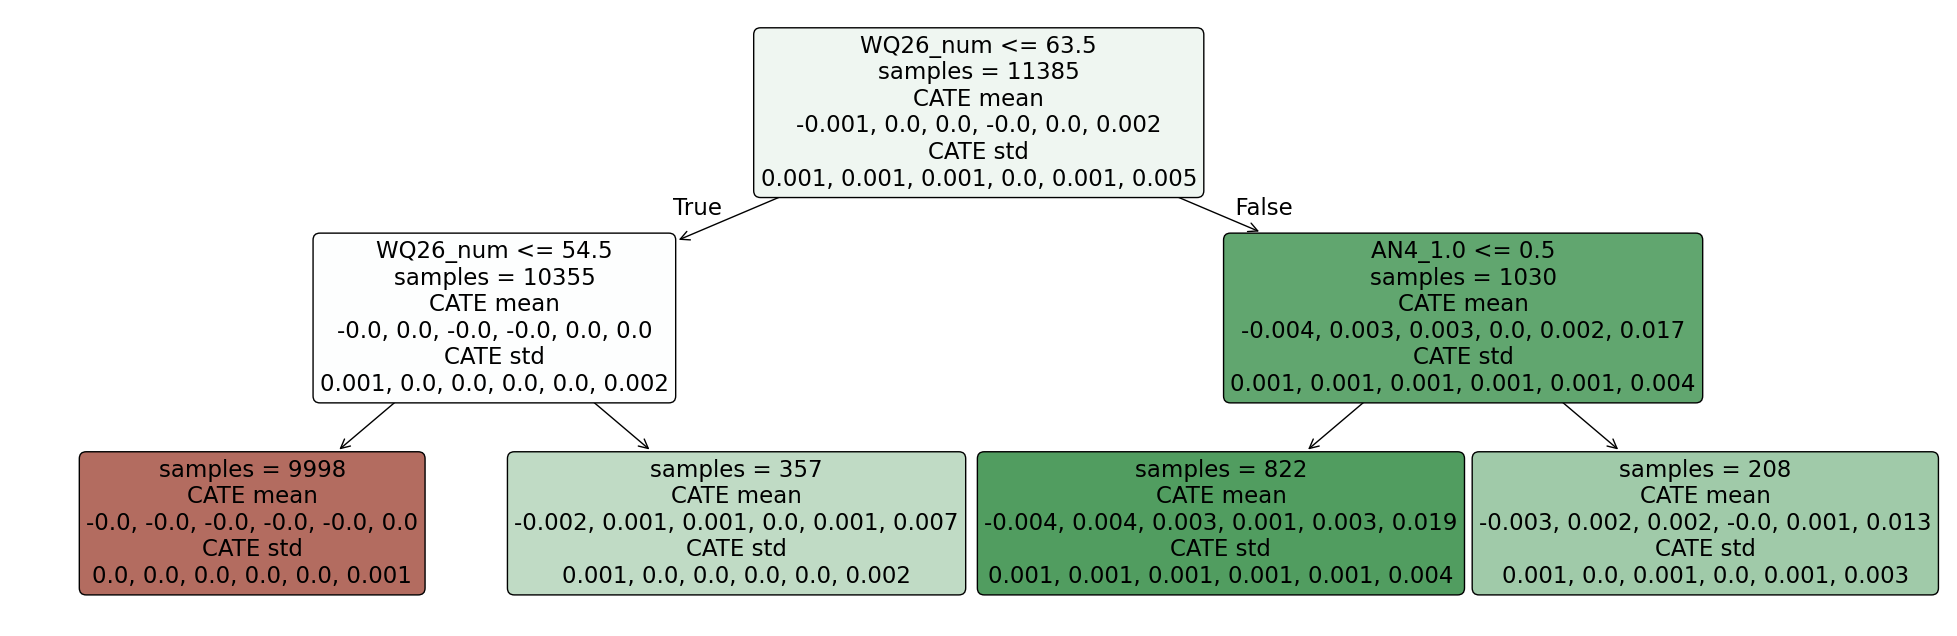

In [ ]:
intrp = SingleTreeCateInterpreter(max_depth=2)
intrp.interpret(crf_ecoli, X)
plt.figure(figsize=(25, 8))
intrp.plot(feature_names=X.columns, treatment_names=t_names)

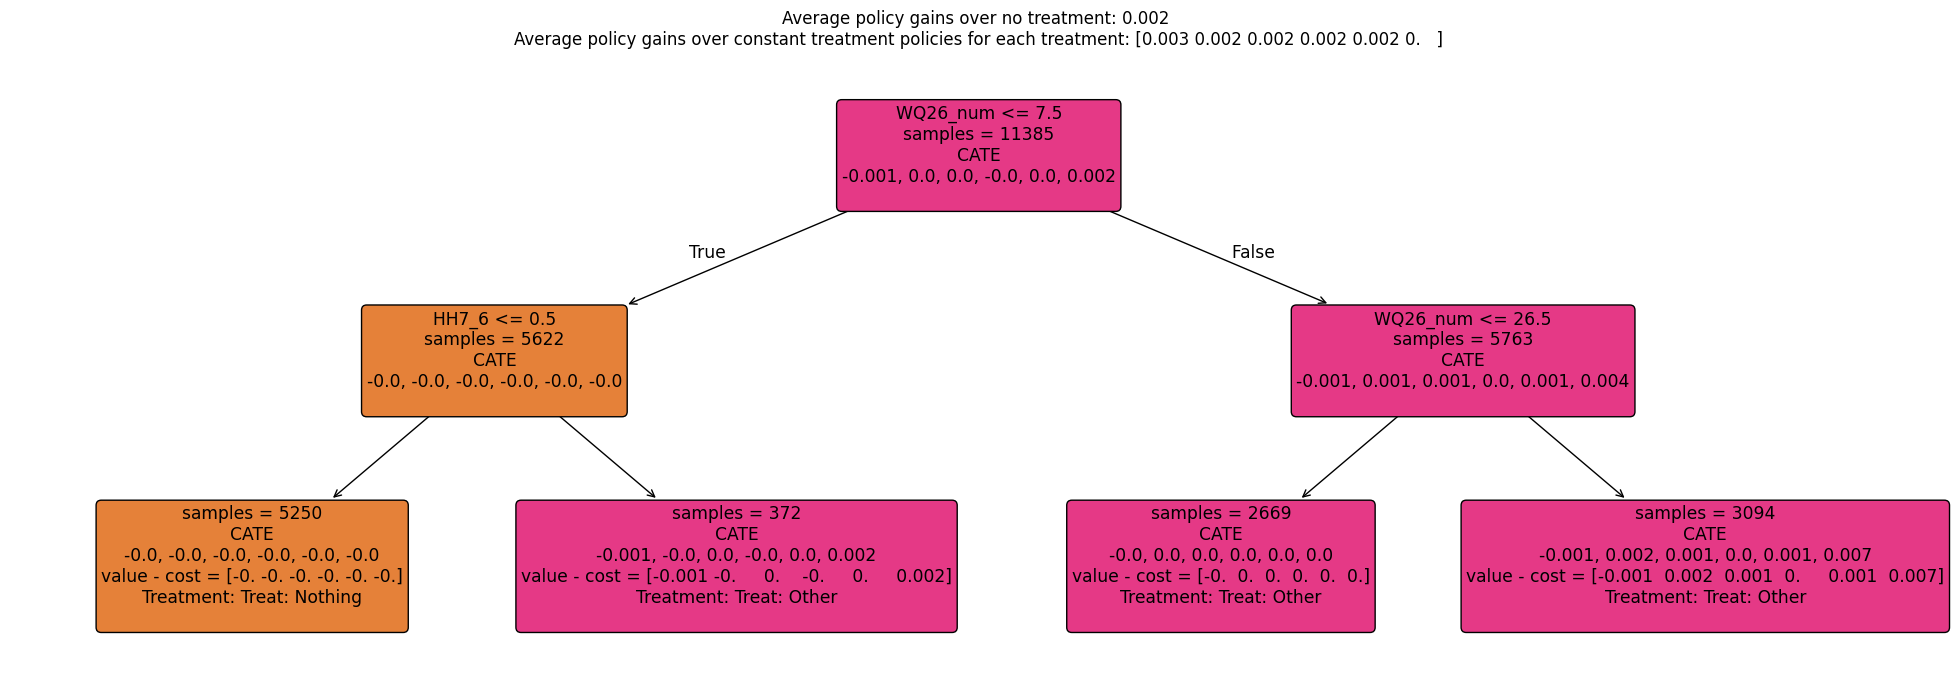

In [ ]:
intrp = SingleTreePolicyInterpreter(max_depth=2)
intrp.interpret(crf_ecoli, X)
plt.figure(figsize=(25, 8))
intrp.plot(feature_names=X.columns, treatment_names=t_names)

## Repeat for E. coli with binary treatment `water_treatment`
Reuse the water-treatment indicator to mirror the three estimators for the E. coli outcome.

In [ ]:
# Outcome and treatment for binary water_treatment subset
y_ecoli_water = binary['WQ26_num']
T_water = binary['water_treatment'].astype(int)


### LinearDML with binary treatment (E. coli)
Baseline double ML with binary treatment.

In [ ]:
ldml_ecoli_water = LinearDML(
    model_y=clone(learner_y),
    model_t=clone(learner_t),
    discrete_treatment=True,
    cv=5,
    random_state=42
)

ldml_ecoli_water.fit(
    Y=y_ecoli_water,
    T=T_water,
    X=X_water,
    W=W_water
)

In [ ]:
#ldml_ecoli_water.summary()

In [ ]:
ldml_ecoli_water.ate_inference(X_water)

### Causal Forest with nuisance Lasso (binary treatment, E. coli)
L1 nuisances for binary treatment.

In [ ]:
lasso_ecoli_water = CausalForestDML(
    model_y=WeightedLassoCVWrapper(),
    model_t=clone(learner),
    discrete_treatment=True,
    min_samples_leaf=200,
    random_state=42,
    n_jobs=-1
)

lasso_ecoli_water.fit(y_ecoli_water, T_water, X=X_water.astype(float), W=W_water.astype(float))

In [ ]:
lasso_ecoli_water.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.01,0.007,1.399,0.162,-0.004,0.024
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.019,0.005,3.621,0.0,0.009,0.029
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.046,0.039,-1.189,0.235,-0.123,0.03


In [ ]:
lasso_ecoli_water.ate_inference(X_water)

### Causal Forest with LightGBM nuisances (binary treatment, E. coli)
Tree-based nuisances for the binary treatment arm.

In [ ]:
crf_ecoli_water = CausalForestDML(
    model_y=clone(learner_y),
    model_t=clone(learner_t),
    min_samples_leaf=200,
    discrete_treatment=True,
    random_state=42,
    n_jobs=-1,
    cv=4
)

crf_ecoli_water.fit(y_ecoli_water, T_water, X=X_water, W=W_water)

In [ ]:
crf_ecoli_water.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.0,0.0,0.936,0.349,-0.0,0.0
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.0,0.0,5.462,0.0,0.0,0.0
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.0,0.0,-0.977,0.329,-0.001,0.0


In [ ]:
#crf_ecoli_water.ate_inference(X_water)